# Wumpus variant Bayes Network 
---

*©Alessandro D'Amico      \|   May 2022*

### Introduction
The focus of this work is on the creation of a probabilistic model in the form of a Bayes Network that can allow us to take decisions in a setting affected by uncertainty. In this specific case, we analize a simplified version of the Wumpus Game, as described below.
### Wumpus Game - a variant
In this setting we consider:
- a **single player**
- the player is inside a grid of dimension **n x n** 
- the player can **move left,right,up,down**
- the player has a certain number of **objectives** to reach (which we call *treasures*)
- the player **mustn't fall inside prohibited cells**  (which we call *pits*) - if this happens, the player dies and the **game is over**.
- In order to avoid falling in a *pit*, the player can take a decision on the basis of its perceptions: **in the left, right, up and down cells of the pit a danger is perceived** (which we call *breeze*) 
- **If the player finds a *tresure*, the game is won** and the match is finished. 

### An example of a use case - drone patrol
To better understand a description of the use case, we can think of a flying drone searching for an item in a grid. If the drone finds the item its mission is completed with success, if instead it flies inside a no-fly zone (after a warning received during its approach), it is shot down and the mission is failed.

### A probabilistic approach
In a fully automatic approach we would just backtrack in safer cells when a danger is detected, but in most of the cases the player would just come back to the starting position's neighborhood. We want to avoid this behavior using the knowledge gained during the exploration of the table done by the player.

Since the most important thing in the game is to avoid the loss/death of the player, I've focused my model on the probability of getting in a pit when visiting a new position of the grid. In order to do this it is necessary to **consider the probability of falling in a pit when going left, right, up and down** (n.b.: this is the most **complete case**, for instance if we're in the bottom-left corner we just need to consider this probability for the right and up position respectively to the actual position of the player).
To compute the probability of getting into a *pit* I've exploited the structure of the *pit* itself: if this happens, the left, right, down and up cells are marked with *breeze*, unless there is a *treasure* or another *pit*.

Taking into account these features, i've drawn the Bayes Newtork below :

![My bayes network for wumpus](images/WumpusDiagram.png)

This graph is an example that shows how the network should be built if we're interesting in knowing the probability of having a *pit* in (5,6) (row 5 column 6). The Black nodes in the intermediate levels are the neighbouring pits of the neighbouring nodes - notice that all of these black nodes should clearly influence even other nodes that, however, are not present in the graph: for instance, if there's a pit in (5,4), this will also influence the 4 nodes around (5,4) and not just (5,5). 

The reason behind the way i built the network (ignoring the other children of the parents of the children) is because we're only interested in querying about the probability of having a pit in the dark-red node, and to do that it is sufficient to consider the ***markov blanket*** of that node (that includes the parents of the queried node, the children and the parents of the children). In this way we build a new network every time we ask for the probability of having a *pit* in a different node. An alternative could have been considering all the possible states of each position in the grid:

- safe
- danger (*breeze*)
- death (*pit*)
- objective (*treasure*)

and this for each of the nxn positions of the grid - the complexity of that structure is really high and the probabilities of falling in a *breeze* cell are not trivial, therefore i decided to avoid that kind of architecture.

### Using evidence gained during the exploration of the table
The more the player has traversed the table, the more evidence we can use to obtain the probability of having a *pit* in a certain node. Notice that we're considering just the knowledge we have about neighbouring cells, so if I actually know something about them i can inject it in my Bayes network as **evidence**, otherwise i just ask the network without any evidence: i've implemented this mechanism querying a dictionary that collects all the states in which i've found *breeze*.

We make the assumption that the probability of having a *pit* in position (i,j) is $$P(pit_{(i,j)}) = \frac{n_{pits}}{n_{unseen}}$$
where $n_{pits}$ is the number of pits we decided to have in the table and $n_{unseen}$ is the number of positions in the board whose are still not visited (and whose state is unknown). When the game starts $n_{unseen} = (table_{size})^2 - 1$ because the player starts in a position (whose state can be both *breeze* or *safe*). $table_{size}$ is the size of the side of the table.

The probability of having *breeze* in position (i,j) $P(breeze_{(i,j)})$ is instead way more complex and we can express it through the following table:

| Pit(i,j)| Pit(i,j-1) | Pit(i,j+1) | Pit(i+1,j) | Pit(i-1,j) |  P(breeze(i,j) \| Pit(i,j), Pit(i,j-1), Pit(i,j+1), Pit(i+1,j), Pit(i-1,j))|
|:-:|:-:|:-:|:-:|:-:|:-:|
| 0 | 0 | 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 1 | 1-P(treasure) |
| 0 | 0 | 0 | 1 | 0 | 1-P(treasure) |
| 0 | 0 | 0 | 1 | 1 | 1-P(treasure) |
| 0 | 0 | 1 | 0 | 0 | 1-P(treasure) |
| 0 | 0 | 1 | 0 | 1 | 1-P(treasure) |
| 0 | 0 | 1 | 1 | 0 | 1-P(treasure) |
| 0 | 0 | 1 | 1 | 1 | 1-P(treasure) |
| 0 | 1 | 0 | 0 | 0 | 1-P(treasure) |
| 0 | 1 | 0 | 0 | 1 | 1-P(treasure) |
| 0 | 1 | 0 | 1 | 0 | 1-P(treasure) |
| 0 | 1 | 0 | 1 | 1 | 1-P(treasure) |
| 0 | 1 | 1 | 0 | 0 | 1-P(treasure) |
| 0 | 1 | 1 | 0 | 1 | 1-P(treasure) |
| 0 | 1 | 1 | 1 | 0 | 1-P(treasure) |
| 0 | 1 | 1 | 1 | 1 | 1-P(treasure) |
| 1 | 0 | 0 | 0 | 0 | 0 |
| 1 | 0 | 0 | 0 | 1 | 0 |
| 1 | 0 | 0 | 1 | 0 | 0 |
| 1 | 0 | 0 | 1 | 1 | 0 |
| 1 | 0 | 1 | 0 | 0 | 0 |
| 1 | 0 | 1 | 0 | 1 | 0 |
| 1 | 0 | 1 | 1 | 0 | 0 |
| 1 | 0 | 1 | 1 | 1 | 0 |
| 1 | 1 | 0 | 0 | 0 | 0 |
| 1 | 1 | 0 | 0 | 1 | 0 |
| 1 | 1 | 0 | 1 | 0 | 0 |
| 1 | 1 | 0 | 1 | 1 | 0 |
| 1 | 1 | 1 | 0 | 0 | 0 |
| 1 | 1 | 1 | 0 | 1 | 0 |
| 1 | 1 | 1 | 1 | 0 | 0 |
| 1 | 1 | 1 | 1 | 1 | 0 |


In the first 16 rows we consider the case in which there's no *pit* in the corresponding position. Apart from the first row, in which we consider the event of having no pit in the 4 neighbouring positions (and consequently no *breeze* in that position), in the other cases we always have at least one of the 4 neighbouring position containing a *pit*. In those cases the probability is not precisely 1, because we have to consider the fact that during the table generation the *treasures* are placed after the *pits* and can actually replace a *breeze cell*, so the probability of having *breeze* will be $1-P(treasure)$, where $$P(treasure) = \frac{n_{treasures}}{n_{unseen}}$$  
Where $n_{treasures}$ is the total number of treasures we decided to have in the game board.

In the last 16 rows we consider the case in which there's a *pit* in the corresponding position, in that case it is clearly not possible to find *breeze* because the states of the positions are mutually exclusive one eachother. 

### Creating and starting the game
I've realized the full logic and GUI of the game. It's possible to create a new game providing the size of the table `table_size`, the number of pits that must be spawned in the game `n_pits` and the number of objectives `n_treasures`.
The aim of this notebook is clearly not to be a game platform, but we're instead interested on the way we can use a Bayesian Network to decide in which direction we should go, according to the knowledge gained while navigating inside the table.

### Implementation of the game board (skip if you're not interested)

In [1]:
%matplotlib inline
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import numpy as np
import matplotlib.pyplot as plt


# TODO add move counter

# functions to check if a position is on a border
def up_border(table_size, i,j):
    return (i==0)
def down_border(table_size, i,j):
    return (i == table_size-1)
def left_border(table_size, i,j):
    return (j == 0)
def right_border(table_size, i,j):
    return (j == table_size-1)

# in this game 0==safe zone    1==danger zone    2==pit    5==treasure
class Game:
    '''
    In this implementation, the class Game represents the gameboard for the modified Wupus game 
    having a board of dimension (table_size * table_size) containing n_pits pits, n_treasures treasures
    and whose player starts in position (table_size-1,0).
    
    Creating a Game with 'example=False' a default (10*10) table with one pit in fixed position and 1 treasure 
    is generated 
    '''
    
    def __init__(self, table_size=10, n_pits=5, n_treasures=1, example=False):
        print("## TABLE GENERATION ##")
        self.table_size = table_size
        self.n_pits = n_pits
        self.n_treasures = n_treasures
        self.table = np.zeros((table_size,table_size))
        self.visited = np.zeros((table_size, table_size), dtype=bool)
        self.player_pos = [table_size-1,0]
        self.visited[self.player_pos[0]][self.player_pos[1]] = True
        self.visited_pos_breeze = {"Breeze_"+str((self.player_pos[0],self.player_pos[1])): int(self.table[self.player_pos[0]][self.player_pos[1]])}

        if (example):
            self.table[7][2] = 2
            self.table[7][1] = 1
            self.table[7][3] = 1
            self.table[6][2] = 1
            self.table[8][2] = 1
            self.table[6][4] = 5
        else:    
            
            #checking legality of parameters
            if(self.n_pits + self.n_treasures + 1 > self.table_size**2):
                raise Exception("chosen parameters are illegal")
            # setting player at defaul position in left bottom corner
            self.set_table()
            self.set_treasure()
            
        print("## GAME STARTED ##")
    
    def get_legal_moves(self):
        legal_moves = []
        if (not up_border(self.table_size, self.player_pos[0],self.player_pos[1])):
            legal_moves.append((self.player_pos[0]-1, self.player_pos[1]))
        if (not down_border(self.table_size, self.player_pos[0],self.player_pos[1])):
            legal_moves.append((self.player_pos[0]+1, self.player_pos[1]))
        if (not left_border(self.table_size, self.player_pos[0],self.player_pos[1])):
            legal_moves.append((self.player_pos[0],self.player_pos[1]-1))
        if (not right_border(self.table_size, self.player_pos[0],self.player_pos[1])):
            legal_moves.append((self.player_pos[0],self.player_pos[1]+1))
        
        return legal_moves
    
    def move_up(self):
        
        new_pos = (self.player_pos[0]-1,self.player_pos[1])
        message = ""
        
        if (new_pos in self.get_legal_moves()):
            self.player_pos[0] = new_pos[0]
            message = self.check_position()
            
            # if the position wasn't visited, add it to the knowlegde base
            if (not self.visited[new_pos[0]][new_pos[1]]):
                self.visited_pos_breeze["Breeze_"+str(new_pos)] = self.table[new_pos[0]][new_pos[1]]
                self.visited[new_pos[0],new_pos[1]] = True
            
            plot_table(self, title="Move: up | "+message)
            
        else:
            raise Exception("this move (move up) is not legal!")
        
        return self
     
    def move_down(self):
        
        new_pos = (self.player_pos[0]+1,self.player_pos[1])
        message = ""        
        if (new_pos in self.get_legal_moves()):
            self.player_pos[0] = new_pos[0]         
            message = self.check_position()
            
            # if the position wasn't visited, add it to the knowlegde base
            if (not self.visited[new_pos[0]][new_pos[1]]):
                self.visited_pos_breeze["Breeze_"+str(new_pos)] = self.table[new_pos[0]][new_pos[1]]
                self.visited[new_pos[0]][new_pos[1]] = True
                
            plot_table(self, title="Move: down | "+message)
            
        else:
            raise Exception("this move (move down) is not legal!")
            
        return self
    
    def move_right(self):
        
        new_pos = (self.player_pos[0],self.player_pos[1]+1)
        message =""
        
        if (new_pos in self.get_legal_moves()):
            self.player_pos[1] = new_pos[1]      
            message = self.check_position()
            
            # if the position wasn't visited, add it to the knowlegde base
            if (not self.visited[new_pos[0]][new_pos[1]]):
                self.visited_pos_breeze["Breeze_"+str(new_pos)] = self.table[new_pos[0]][new_pos[1]]
                self.visited[new_pos[0]][new_pos[1]] = True
            
            plot_table(self, title="Move: right | "+message)
            
        else:
            raise Exception("this move (move right) is not legal!")
        
        return self
    
    def move_left(self):
        
        new_pos = (self.player_pos[0],self.player_pos[1]-1)
        message=""
        
        if (new_pos in self.get_legal_moves()):
            self.player_pos[1] = new_pos[1]
            message = self.check_position()
            
            # if the position wasn't visited, add it to the knowlegde base
            if (not self.visited[new_pos[0]][new_pos[1]]):
                self.visited_pos_breeze["Breeze_"+str(new_pos)] = self.table[new_pos[0]][new_pos[1]]
                self.visited[new_pos[0]][new_pos[1]] = True
                
            plot_table(self, title="Move: left | "+message)
                
        else:
            raise Exception("this move (move left) is not legal!")
        
        return self
    
    def check_position(self):
        if (self.table[self.player_pos[0]][self.player_pos[1]] == 0):
            return " player is in SAFE zone "
        elif (self.table[self.player_pos[0]][self.player_pos[1]] == 1):
            return " player is in DANGER zone "
        elif (self.table[self.player_pos[0]][self.player_pos[1]] == 5):
            raise Exception("## YOU WIN ## You fell into a pit")
        elif (self.table[self.player_pos[0]][self.player_pos[1]] == 2):
            raise Exception("## GAME OVER ## You fell into a pit")
        else:
            raise Exception("GAME CRASHED")

    
    #generating table
    def set_table(self): 
        for k in range(self.n_pits):
            while(True):
                rand_pos = np.random.randint(0,self.table_size,2)
                if(any(rand_pos != self.player_pos) and self.table[rand_pos[0]][rand_pos[1]]!=2):
                    break
                    
            self.table[rand_pos[0]][rand_pos[1]] = 2
            
            if (rand_pos[0]>0):
                self.table[rand_pos[0]-1][rand_pos[1]] = max(self.table[rand_pos[0]-1][rand_pos[1]], 1)
            if (rand_pos[0]<self.table_size-1):
                self.table[rand_pos[0]+1][rand_pos[1]] = max(self.table[rand_pos[0]+1][rand_pos[1]], 1)
            if (rand_pos[1]>0):
                self.table[rand_pos[0]][rand_pos[1]-1] = max(self.table[rand_pos[0]][rand_pos[1]-1], 1)
            if (rand_pos[1]<self.table_size-1):
                self.table[rand_pos[0]][rand_pos[1]+1] = max(self.table[rand_pos[0]][rand_pos[1]+1], 1)

        return self.table
    
    #setting treasure
    def set_treasure(self):
        for k in range(self.n_treasures):
            while(True):
                rand_pos =np.random.randint(0,self.table_size,2)
                if(any(rand_pos != self.player_pos) and self.table[rand_pos[0]][rand_pos[1]]!=2 and self.table[rand_pos[0]][rand_pos[1]]!=5):
                    break

            self.table[rand_pos[0]][rand_pos[1]]= 5

        return self.table


def plot_table(game, title="None"):
    table = game.table
    player_pos = game.player_pos
    
    fig, ax = plt.subplots(1,1) #figsize=(5,5)
    fig.suptitle(title, fontsize=12)
    ax.imshow(table, cmap='Greys', origin='upper', vmin=0, vmax=5.)

    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(0, game.table_size, 1)
    minor_ticks = np.arange(0.5, game.table_size, 0.5)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.plot(player_pos[1], player_pos[0], marker="o", markersize=15, markeredgecolor="red", markerfacecolor="orange")
    
    for i in range(0,game.visited.shape[0]):
        for j in range(0,game.visited.shape[1]):
            if (game.visited[i][j]):
                ax.plot(j, i, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="red")
    
    # And a corresponding grid
    ax.grid(which='minor', color='k')
    plt.show()

### Implementation of player's decision engine
Here follows the implementation of the mechanism used to automatically generate the probability of falling in a pit in a given target position on the basis of the knowledge gained in the previously visited states. I've used the library `pgmpy` to represent the probability tables, generate the nodes with the corresponding arcs and finally query the built network.

In [2]:
from pgmpy.inference import VariableElimination
#from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling
import networkx as nx
import pylab

def prob_LW(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/(np.sum(samples['_weight'])+(np.finfo(np.float64).tiny)),2)


def get_bayesnet_by_node(game, target, print_verbose=False, inference_type="exact", n_samples = 10000):
    '''
    This function implements the Bayes Network to calculate the probability of having a pit in a target position
    of the modified Wumpus game.
    
    input:
        target: the position (x,y) for which the probability of having a pit has to be computed
        print_verbose: set to True if ypu want to see the CPDs and the corresponding BN graph
        inference_type: "exact" for exact inference, "approx" for Likelihood Weighting inference
        n_samples: the number of samples to use when inexact inference is used
    
    output:
        The probability of having a pit in target position P(target=pit)
    
    '''
    if(print_verbose):
        print("###### COMPUTING PROBABILITY OF HAVING A PIT IN POSITION {} ######".format(target))
    
    if ((target[0]<0) or (target[0]>game.table_size) or (target[1]<0) or (target[1]>game.table_size)):
        raise Exception("the target cell "+ str(target)+" is outside the table, which dimension is "+ str((game.table_size,game.table_size)))


        
    table_size = game.table_size
    n_pits = game.n_pits
    table = game.table

    i= target[0]
    j= target[1]
    
    n_unseen_cells = (table_size)**2 - np.count_nonzero(game.visited) 
    
    # probability of having a pit in one position
    p_pit = float(n_pits/n_unseen_cells)
    
    # probability of having a treasure in one position
    p_treasure = float(game.n_treasures /n_unseen_cells) 
    
    down = (i+1,j)
    up =  (i-1,j)
    left = (i,j-1)
    right = (i,j+1)

    # exit if the value of the cell is already known (already visited)
    if (("Breeze_"+str(target)) in game.visited_pos_breeze.keys()):
        if(print_verbose):
            print("# Node already visited #")
        return game.visited_pos_breeze[("Breeze_"+str(target))]

    
    # exit if probability of falling in a pit is 1 or 0 (in that case other computations are meaningless)
    if (p_pit == (1 or 0)):
        return p_pit
    
    # adding the cpd of the cell asked by the query
    cpds={TabularCPD(variable="Pit_"+str(target), variable_card=2, values=[[1-p_pit], [p_pit]])}
    arcs = []
    pos_to_check= set()
    pos_to_check.add("Breeze_"+str((target[0],target[1])))
    
    if (left_border(game.table_size,target[0], target[1]) is False):
        
        # left node (i,j-1)
        son_parents = []
        
        # considering the probability of having a pit also in the left position
        arcs.append(("Pit_"+str(left), "Breeze_"+str(left)))
        son_parents.append("Pit_"+str(left))
        cpds.add(TabularCPD(variable="Pit_"+str(left), variable_card=2, values=[[1-p_pit], [p_pit]]))
        
        # adding the cell in left position 
        arcs.append(("Pit_"+str(target),"Breeze_"+str(left)))
        son_parents.append("Pit_"+str(target))
        pos_to_check.add("Breeze_"+str(left))
        
        # connections of the left node
        if (left_border(game.table_size, left[0],left[1]) is False):
            arcs.append(("Pit_"+str((i,j-2)),"Breeze_"+str(left))) #left 
            son_parents.append("Pit_"+str((i,j-2)))
            cpds.add(TabularCPD(variable="Pit_"+str((i,j-2)), variable_card=2, values=[[1-p_pit],[p_pit]]))
        if (up_border(game.table_size, left[0], left[1]) is False):
            arcs.append(("Pit_"+str((i-1,j-1)),"Breeze_"+str(left))) #up  
            son_parents.append("Pit_"+str((i-1,j-1)))
            cpds.add(TabularCPD(variable="Pit_"+str((i-1,j-1)), variable_card=2, values=[[1-p_pit], [p_pit]]))
        if (down_border(game.table_size,left[0],left[1]) is False):
            arcs.append(("Pit_"+str((i+1,j-1)),"Breeze_"+str(left))) #down
            son_parents.append("Pit_"+str((i+1,j-1)))
            cpds.add(TabularCPD(variable="Pit_"+str((i+1,j-1)), variable_card=2, values=[[1-p_pit], [p_pit]]))

        cpd_left = TabularCPD(
            variable="Breeze_"+str(left),
            variable_card=2,
            values=[[1] + ([p_treasure]*(int((2**len(son_parents))/2) - 1)) + ([1]*int(((2**len(son_parents))/2))) , # case breeze  = false                    [0] + ([1]*(int((2**len(son_parents))/2) - 1)) + ([0]*int(((2**len(son_parents))/2)))], # case breeze = true
                    [0] + ([1-p_treasure]*(int((2**len(son_parents))/2) - 1)) + ([0]*int(((2**len(son_parents))/2)))],
            evidence=son_parents,
            evidence_card=[2]*len(son_parents),
        )

        cpds.add(cpd_left)

    if (right_border(game.table_size,target[0], target[1]) is False):
        
        # right node (i,j+1)  
        son_parents = []
        
        # considering the probability of having a pit also in the right position
        arcs.append(("Pit_"+str(right), "Breeze_"+str(right)))
        son_parents.append("Pit_"+str(right))
        cpds.add(TabularCPD(variable="Pit_"+str(right), variable_card=2, values=[[1-p_pit], [p_pit]]))
        
        # adding the cell in right position
        arcs.append(("Pit_"+str(target),"Breeze_"+str(right)))
        son_parents.append ("Pit_"+str(target))
        pos_to_check.add("Breeze_"+str(right))
        
        # connections of the right node
        if(down_border(game.table_size, right[0], right[1]) is False):
            arcs.append(("Pit_"+str((i+1,j+1)),"Breeze_"+str(right))) #down
            son_parents.append("Pit_"+str((i+1,j+1)))
            cpds.add(TabularCPD(variable="Pit_"+str((i+1,j+1)), variable_card=2, values=[[1-p_pit], [p_pit]]))
        if(up_border(game.table_size, right[0], right[1]) is False):
            arcs.append(("Pit_"+str((i-1,j+1)),"Breeze_"+str(right))) #up
            son_parents.append("Pit_"+str((i-1,j+1)))
            cpds.add(TabularCPD(variable="Pit_"+str((i-1,j+1)), variable_card=2, values=[[1-p_pit], [p_pit]]))
        if(right_border(game.table_size, right[0], right[1]) is False):
            arcs.append(("Pit_"+str((i,j+2)),"Breeze_"+str(right))) #right
            son_parents.append("Pit_"+str((i,j+2)))
            cpds.add(TabularCPD(variable="Pit_"+str((i,j+2)), variable_card=2, values=[[1-p_pit], [p_pit]]))
            
        cpd_right = TabularCPD(
            variable="Breeze_"+str(right),
            variable_card=2,
            values=[[1] + ([p_treasure]*(int((2**len(son_parents))/2) - 1)) + ([1]*int(((2**len(son_parents))/2))) ,  # case breeze  = false
                    [0] + ([1-p_treasure]*(int((2**len(son_parents))/2) - 1)) + ([0]*int(((2**len(son_parents))/2)))],
            evidence=son_parents,
            evidence_card=[2]*len(son_parents),
        )

        
        cpds.add(cpd_right)

    if (up_border(game.table_size,target[0], target[1]) is False):
        
        # up node (i-1,j)
        son_parents = []
        
        # considering the probability of having a pit also in the up position
        arcs.append(("Pit_"+str(up), "Breeze_"+str(up)))
        son_parents.append("Pit_"+str(up))
        cpds.add(TabularCPD(variable="Pit_"+str(up), variable_card=2, values=[[1-p_pit], [p_pit]]))
        
        # adding the cell in up position
        arcs.append(("Pit_"+str(target),"Breeze_"+str(up)))
        son_parents.append("Pit_"+str(target))
        pos_to_check.add("Breeze_"+str(up))
        
        # connections of the up node
        if(up_border(game.table_size, up[0],up[1]) is False):
            arcs.append(("Pit_"+str((i-2,j)),"Breeze_"+str(up))) #up
            son_parents.append("Pit_"+str((i-2,j)))
            cpds.add(TabularCPD(variable="Pit_"+str((i-2,j)), variable_card=2, values=[[1-p_pit], [p_pit]]))
        if(left_border(game.table_size, up[0],up[1]) is False):
            arcs.append(("Pit_"+str((i-1,j-1)),"Breeze_"+str(up))) #left
            son_parents.append("Pit_"+str((i-1,j-1)))
            cpds.add(TabularCPD(variable="Pit_"+str((i-1,j-1)), variable_card=2, values=[[1-p_pit], [p_pit]]))
        if(right_border(game.table_size, up[0],up[1]) is False):
            arcs.append(("Pit_"+str((i-1,j+1)),"Breeze_"+str(up))) #right
            son_parents.append("Pit_"+str((i-1,j+1)))
            cpds.add(TabularCPD(variable="Pit_"+str((i-1,j+1)), variable_card=2, values=[[1-p_pit], [p_pit]]))

        cpd_up = TabularCPD(
            variable="Breeze_"+str(up),
            variable_card=2,
            values=[[1] + ([p_treasure]*(int((2**len(son_parents))/2) - 1)) + ([1]*int(((2**len(son_parents))/2))) , # case breeze  = false                    [0] + ([1]*(int((2**len(son_parents))/2) - 1)) + ([0]*int(((2**len(son_parents))/2)))], # case breeze = true
                    [0] + ([1-p_treasure]*(int((2**len(son_parents))/2) - 1)) + ([0]*int(((2**len(son_parents))/2)))],
            evidence=son_parents,
            evidence_card=[2]*len(son_parents),
        )

        cpds.add(cpd_up)

    if (down_border(game.table_size,target[0], target[1]) is False):
        
        #down (i+1,j)
        son_parents = []
        
        # considering the probability of having a pit also in the down position
        arcs.append(("Pit_"+str(down), "Breeze_"+str(down)))
        son_parents.append("Pit_"+str(down))
        cpds.add(TabularCPD(variable="Pit_"+str(down), variable_card=2, values=[[1-p_pit], [p_pit]]))
        
        # adding the cell in down position
        arcs.append(("Pit_"+str(target),"Breeze_"+str(down))) # sotto
        son_parents.append("Pit_"+str(target))
        pos_to_check.add("Breeze_"+ str(down))
        
        # connections of the down node
        if(left_border(game.table_size,down[0],down[1]) is False):
            arcs.append(("Pit_"+str((i+1,j-1)),"Breeze_"+str(down))) #left
            son_parents.append("Pit_"+str((i+1,j-1)))
            cpds.add(TabularCPD(variable="Pit_"+str((i+1,j-1)), variable_card=2, values=[[1-p_pit], [p_pit]]))
        if(right_border(game.table_size,down[0],down[1]) is False):
            arcs.append(("Pit_"+str((i+1,j+1)),"Breeze_"+str(down))) #right
            son_parents.append("Pit_"+str((i+1,j+1)))
            cpds.add(TabularCPD(variable="Pit_"+str((i+1,j+1)), variable_card=2, values=[[1-p_pit], [p_pit]]))
        if(down_border(game.table_size,down[0],down[1]) is False):
            arcs.append(("Pit_"+str((i+2,j)),"Breeze_"+str(down))) #down
            son_parents.append("Pit_"+str((i+2,j)))
            cpds.add(TabularCPD(variable="Pit_"+str((i+2,j)), variable_card=2, values=[[1-p_pit], [p_pit]]))

        cpd_down = TabularCPD(
            variable="Breeze_"+str(down),
            variable_card=2,
            values=[[1] + ([p_treasure]*(int((2**len(son_parents))/2) - 1)) + ([1]*int(((2**len(son_parents))/2))) , # case breeze  = false
                    [0] + ([1-p_treasure]*(int((2**len(son_parents))/2) - 1)) + ([0]*int(((2**len(son_parents))/2)))],
            evidence=son_parents,
            evidence_card=[2]*len(son_parents),
        )

        cpds.add(cpd_down)
    
    # Adding all the arcs to the BN
    model = BayesianNetwork(arcs)

    # Adding all the cpds (node-tables) to the BN
    model.add_cpds(*cpds)
    
    # Checking if the cpds are valid to build a BN.
    model.check_model() 
    
    if (print_verbose):
        print(model)
        # Associating the parameters with the model structure.
        
        for i in cpds:
            print(i)
    
        nx.draw(model, with_labels=True)
        pylab.show()
    
    
    if(inference_type == 'exact'):
        inference = VariableElimination(model)
        
        # checking if positions in pos_to_check are already in game.pos_visited_breeze, add them to evidence in that case 
        my_evidence = {key:game.visited_pos_breeze.get(key) for key in pos_to_check 
                       if key in game.visited_pos_breeze.keys()}
        query = inference.query(["Pit_"+str(target)] , evidence = my_evidence, show_progress = print_verbose)
    
    elif(inference_type =='approx'):
        inference = BayesianModelSampling(model)
       
        # checking if positions in pos_to_check are already in game.pos_visited_breeze, add them to evidence in that case 
        my_evidence = {key:game.visited_pos_breeze.get(key) for key in pos_to_check 
                       if key in game.visited_pos_breeze.keys()}
        #query = inference.query(["Pit_"+str(target)] , n_samples = n_samples,  evidence = my_evidence, show_progress = print_verbose)    
        query = prob_LW(inference.likelihood_weighted_sample(evidence = list(my_evidence.items()), size=n_samples, show_progress=print_verbose), "Pit_"+str(target))
        
    if(print_verbose):
        print(query)
    
    
    if(inference_type=='exact'):
        if(len(query.values) ==1):
            return 0
        else:
            return query.values[1]
        
    
    # probability of having a pit in target position
    return query



#### Implementation of an interface to detect the feasible moves for the actual position of the player (skip if not interested)
With the following code the possible moves that the player can do are automatically detected (they can be at most four: left, right, up, down) and for each of them the probability of getting in a pit is computed through the creation of a bayes network for each of them (in the way that is done for a single position in the cell before this one). 

In [3]:
import time

def get_player_moves(game,print_verbose, inference_type="exact", n_samples = 10000):
    
    start_time = time.perf_counter()
    moves = dict()
    weighted = dict()
    sum_ = 0
    if (game.player_pos[0]-1 >= 0): # up
        moves['UP'] = get_bayesnet_by_node(game,(game.player_pos[0]-1,game.player_pos[1]), print_verbose, inference_type, n_samples)
        sum_ += moves['UP'] 
    if (game.player_pos[0]+1 < game.table_size): #down
        moves['DOWN']=get_bayesnet_by_node(game,(game.player_pos[0]+1,game.player_pos[1]), print_verbose, inference_type, n_samples)
        sum_ += moves['DOWN']
    if (game.player_pos[1]+1 < game.table_size): #right
        moves['RIGHT']=get_bayesnet_by_node(game,(game.player_pos[0],game.player_pos[1]+1), print_verbose, inference_type, n_samples)
        sum_ += moves['RIGHT']
    if (game.player_pos[1]-1 >= 0): #left
        moves['LEFT']=get_bayesnet_by_node(game,(game.player_pos[0],game.player_pos[1]-1), print_verbose, inference_type, n_samples)
        sum_ += moves['LEFT']
        
    end_time = time.perf_counter()
    
    elapsed_time = end_time - start_time
    
    if (print_verbose):
        print("#################################################")
    
    return moves, elapsed_time



### Proving the functioning of this tool with an example

First of all, we have to generate a game board - using `example=True` i generate a default 10x10 table with one pit in position (7,2), a treasure (6,4) and a player with starting position (9,0). 
- The visited positions are marked with red points with blue border (the player is aware just of the states of these cells)
- The actual position of the player is represented by an orange circle with red border
- The *breeze* position is represented by a light-grey circle
- The *pit* position is represented by a dark-grey circle


In [4]:
#game = Game(table_size = 10, n_pits = 6, n_treasures = 1)
game = Game(example=True)

## TABLE GENERATION ##
## GAME STARTED ##


Then, we make 3 moves just to gain some knowledge: up, right, right.

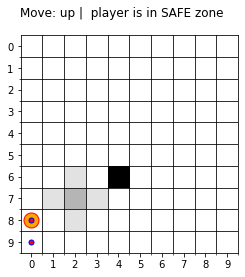

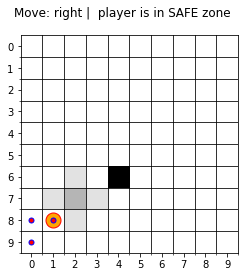

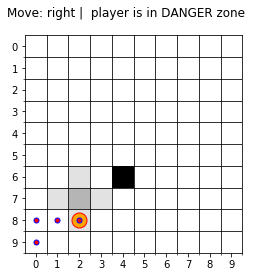

In [5]:
game.move_up()
game.move_right()
game.move_right()

We ask for $P(pit)$ for the left position to see how the CPDs an the BN are generated:

###### COMPUTING PROBABILITY OF HAVING A PIT IN POSITION (7, 2) ######

+------------------+---------------+-----+---------------+---------------+---------------+
| Pit_(7, 3)       | Pit_(7, 3)(0) | ... | Pit_(7, 3)(1) | Pit_(7, 3)(1) | Pit_(7, 3)(1) |
+------------------+---------------+-----+---------------+---------------+---------------+
| Pit_(7, 2)       | Pit_(7, 2)(0) | ... | Pit_(7, 2)(1) | Pit_(7, 2)(1) | Pit_(7, 2)(1) |
+------------------+---------------+-----+---------------+---------------+---------------+
| Pit_(8, 3)       | Pit_(8, 3)(0) | ... | Pit_(8, 3)(1) | Pit_(8, 3)(1) | Pit_(8, 3)(1) |
+------------------+---------------+-----+---------------+---------------+---------------+
| Pit_(6, 3)       | Pit_(6, 3)(0) | ... | Pit_(6, 3)(0) | Pit_(6, 3)(1) | Pit_(6, 3)(1) |
+------------------+---------------+-----+---------------+---------------+---------------+
| Pit_(7, 4)       | Pit_(7, 4)(0) | ... | Pit_(7, 4)(1) | Pit_(7, 4)(0) | Pit_(7, 4)(1) |
+-----------------

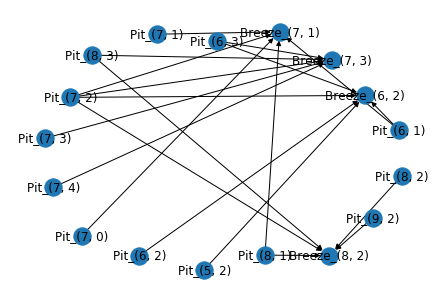


+---------------+-------------------+
| Pit_(7, 2)    |   phi(Pit_(7, 2)) |
+===============+===================+
| Pit_(7, 2)(0) |            0.7296 |
+---------------+-------------------+
| Pit_(7, 2)(1) |            0.2704 |
+---------------+-------------------+
Probability of getting in a pit moving UP:  0.2704011291164047


In [6]:
print("Probability of getting in a pit moving UP: ", get_bayesnet_by_node(game, target=(game.player_pos[0]-1,game.player_pos[1]), print_verbose=True))

Now we ask for $P(pit)$ for all the possible positions to which the player can move without explicitly printing all the tables and all the networks

In [7]:
print("Probability of falling in a Pit by move: ",get_player_moves(game, print_verbose=False, inference_type="exact"))

Probability of falling in a Pit by move:  ({'UP': 0.2704011291164047, 'DOWN': 0.2704011291164047, 'RIGHT': 0.2704011291164047, 'LEFT': 0.0}, 0.10425030000000035)


We have an equal probability of getting into a pit if we choose down, right or up. This is quite intuitive because if we're feeling *breeze* there's at least one pit in one of the 4 neighbouring positions and if we don't have other knowledge each pit can be with the same probability in each of these positions.

We decide to go right, because going backwards (left) we would come back to an already visited path (we could have chosen down or up because there's the same probability of finding a pit). 

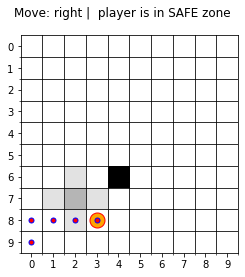

In [8]:
game = game.move_right()

The player is now in a *safe* position (as the already visited (9,0),(8,0) ad (8,1)).
We decide to go up.

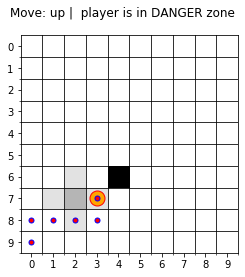

Probability of falling in a Pit by move:  ({'UP': 0.27085459106723525, 'DOWN': 0.0, 'RIGHT': 0.27085459106723525, 'LEFT': 0.47002833680149225}, 0.1212895000000005)


In [9]:
game = game.move_up()
#call bayesian nets to decide next position
print("Probability of falling in a Pit by move: ", get_player_moves(game, print_verbose=False))

The player is clearly not aware of having a pit at its left, but thanks to the Built bayes networks it is able to sense an higher probability of having a pit in that position (in comparison to the other possible moves), because of how the pit structure was geometrically described: knowing that there's *breeze* in (8,2) and (7,3) it is likely to have a pit in (7,2).

# Exact Inference vs Approximate Inference
In this section we will try to compare two possible methods for making inference by means of reliability and time. *Exact Inference* is the usual method that we apply through Variable Elimination, its results are exact and correspond to the results we would have obtained using a big CPT including all of the possible node states. Even if using a BN is in general better than using a single CPT, sometimes it is useful to apply *Approximate Inference* methods, but in that case (if the samples are in small number) the results can be inaccurate -  on the other side, if we use too many samples the processing time can be much higher than the one taken by Exact Inference methods.

Is it worth to use *Approximate Inference* in this case? 
Below I try to ask this question with a benchmark.

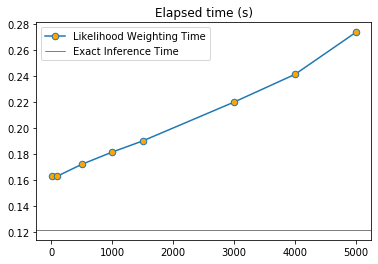

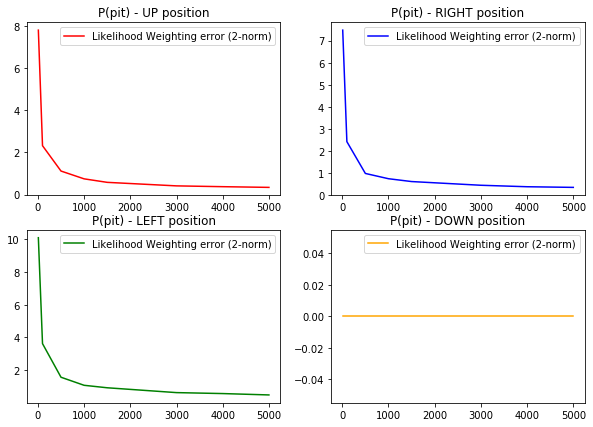

In [10]:
import numpy as np

def plot_comparison(rep=20, sample_n = [10, 100, 500, 1000]):
    '''
    This function plots the graph comparing exact and approximated inference by means of time and error of inexact 
    inference wrt to exact inference values.
    
    input: 
        rep:the number of repetitions (timers are affected by the way the cpu tasks are scheduled)
            setting a high number of repetitions may result in more reliable results but is also a mult factor
            of the total time.
        sample_n: an array with the number of samples to be generated for approximated inference 
    
    output:
        The elapsed time (exacts vs inexact inference) plot.
        The abs. value of the error between exact and inexact values for all the 4 directions. 
        
    '''
    # performing exact inference
    exact_t = []
    for i in range(0,rep+1):
        exact_dict,sample_exact_t = get_player_moves(game, print_verbose=False, inference_type="exact")
        exact_t.append(sample_exact_t)
    
    exact_time = np.average(exact_t)
 
    times_res = []
    left_res = []
    right_res = []
    up_res = []
    down_res = []
    
    # performing sampling multiple times
    for samples in sample_n:
        times = []
        left_ = []
        right_ = []
        up_ = []
        down_ = []

        for i  in range(0,rep+1):
            move_dict, time_ = get_player_moves(game, print_verbose=False, n_samples = samples, inference_type="approx")
            left_.append(move_dict['LEFT'])
            right_.append(move_dict['RIGHT'])
            up_.append(move_dict['UP'])
            down_.append(move_dict['DOWN'])
            times.append(time_)

        times_res.append(np.average(times))
        left_res.append(np.linalg.norm(abs(exact_dict['LEFT'] - left_),2))
        right_res.append(np.linalg.norm(abs(exact_dict['RIGHT'] - right_),2))
        up_res.append(np.linalg.norm(abs(exact_dict['UP'] - up_),2))
        down_res.append(np.linalg.norm(abs(exact_dict['DOWN'] - down_),2))

    plt.plot(sample_n, times_res, marker=".", markersize=13, markerfacecolor="orange", label = "Likelihood Weighting Time") 
    plt.axhline(y=exact_time,linewidth=0.5, color='k', label = 'Exact Inference Time')
    plt.title("Elapsed time (s)")
    plt.legend()

    plt.show()

    fig, ax = plt.subplots(2,2, figsize=(10, 7))       
    ax[0][0].plot(sample_n, up_res, color='red' , label= 'Likelihood Weighting error (2-norm)')
    ax[0][0].set_title("P(pit) - UP position")
    ax[0][0].legend()
    ax[0][1].plot(sample_n, right_res, color='blue', label= 'Likelihood Weighting error (2-norm)')
    ax[0][1].set_title("P(pit) - RIGHT position")
    ax[0][1].legend()
    ax[1][0].plot(sample_n, left_res, color='green', label= 'Likelihood Weighting error (2-norm)')
    ax[1][0].set_title("P(pit) - LEFT position")
    ax[1][0].legend()
    ax[1][1].plot(sample_n, down_res, color='orange', label= 'Likelihood Weighting error (2-norm)')
    ax[1][1].set_title("P(pit) - DOWN position")
    ax[1][1].legend()
    
    plt.show()

plot_comparison(rep=500, sample_n = [10, 100, 500, 1000, 1500, 3000, 4000, 5000])

The built model is already quite small and the variables corresponding to the nodes are binary (so they have relatively small tables), therefore there's no advantage in using *Likelihood Weighting* or any other similar approximate inference technique - consider that *rejection sampling* efficiency is in general lower than LW.

## Conclusions (summary)
- I've implemented the logic of the game board
- **I've implemented and presented a Bayes Network - based solution as decision support tool in an enviroment affected by uncertainty. The Bayes network was built following causality means and, in particular, the features of a geometric pattern.**
- **I've presented a basic example and verified its expected behavior.**
- I've compared ***exact inference* and *inexact (approximated) inference*** for this BN use case 